## Frequency Analysis

Generating a complex pattern (distribution) from a single value can be done with dense layers, conv layer and recurrent layers. Autoencoders and Variational Autoencoders can easily be trained to decode a small latent-space vector into a complex image or waveform.

This document investigates what kinds of networks are best suited to extract the required information needed to re-generate an input waveform.

Ideally, we want a network that performs a component analysis of an input sample, and outputs the frequencies of the sinewaves that it consists of.

In [1]:
from __future__ import division

import keras
from keras import backend as K
from keras.layers import Layer
from keras import activations
from keras import utils
from keras.datasets import cifar10
from keras.models import Model
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
# local libs
import config, models, functions
from data import data, midi, midi_generators as g
from utils import io, models_io, utils, plot
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_instances = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]



In [3]:
context = data.init()
n = 2
dim4 = True
multiTrack = True
context, x_train, labels = data.import_data(data.init(), n, dim4=dim4, multiTrack=multiTrack)

Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Setting up params

max min f 25.0 0.5
 >> Context(max_t=2.0, dt=0.02, n_instances=100, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
Importing midi-data

 [INFO] : 
 |  reading file: ../datasets/examples/01 16th Snare.mid
 [INFO] : 
 |  reading file: ../datasets/examples/01 8th Cym.mid

Encoding midi-data
 [<midi file '../datasets/examples/01 16th Snare.mid' type 0, 1 tracks, 182 messages>, <midi file '../datasets/examples/01 8th Cym.mid' type 0, 1 tracks, 68 messages>]
> -> multi-track = True
 [INFO] : 
 |  reduced dims:
 |  (2, 100, 2)


In [4]:
n = 1000
min_f = 3
max_f = 15
x_train, params = g.gen_data_complex(context, n, max_f=max_f, min_f=min_f,
    n_polyrythms=1,
    n_channels=1,
    d_phase=True,
    return_params=True,
    dim4=dim4,
    multiTrack=multiTrack)

 [INFO] : 
 |  reduced dims:
 |  (1000, 100, 1)


In [5]:
params.shape # n, n_channels, n_polyrythms

(1000, 1, 1)

(array([106.,  94., 105.,  89.,  96.,  84.,  81.,  77.,  85.,  83.]),
 array([ 3.00213658,  4.20183805,  5.40153952,  6.60124098,  7.80094245,
         9.00064392, 10.20034538, 11.40004685, 12.59974832, 13.79944979,
        14.99915125]),
 <a list of 10 Patch objects>)

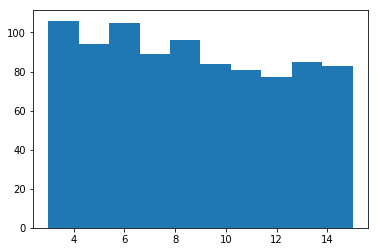

In [6]:
m = int(x_train.shape[0] * 0.9)
# m = 10
plt.hist(params[:m,0,0])

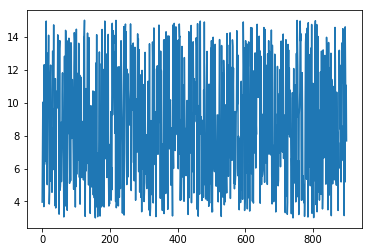

In [7]:
plt.plot(params[:m,0,0])

In [8]:
range_ = (max_f - min_f)
y_train = (params[:,0,0] - min_f) / range_
y_train.shape

(1000,)

In [9]:
x_train.shape

(1000, 100, 1, 1)

In [10]:
x_test = x_train[m:]
x_train = x_train[:m]
y_test = y_train[m:]
y_train = y_train[:m]

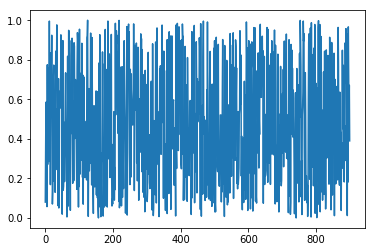

In [11]:
plt.plot(y_train)

m (30, 1)


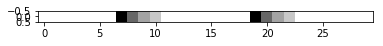

m (30, 1)


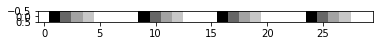

[0.08007997 0.30886331]


In [12]:
i = 0
plot.single(x_train[i,:30,0])
plot.single(x_train[i+1,:30,0])
print(y_train[i:i+2])

Make sure all frequencies fall inside the window

m (30, 1)


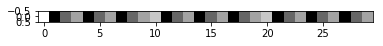

m (30, 1)


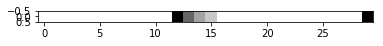

0.9999292711401816 0.00017804838165758063


In [13]:
i = y_train.argmax()
j = y_train.argmin()
plot.single(x_train[i,:30,0])
plot.single(x_train[j,:30,0])
print(y_train[i], y_train[j])

In [14]:
input_shape = x_train[0].shape
input_shape

(100, 1, 1)

In [15]:
timesteps, notes, channels = input_shape

encoder_input = Input(shape=(timesteps, notes, channels))
x = encoder_input

x = Reshape((timesteps, notes))(x)
x = SimpleRNN(1)(x)
x = Dense(1, activation='sigmoid')(x)

encoder_output = x

encoder_model = Model(encoder_input, encoder_output, name='encoder-')
encoder_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100, 1, 1)         0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 100, 1)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 1)                 3         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


In [97]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta
encoder_model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','binary_crossentropy'])

In [98]:
phase_mod = 0.1
whitening = False

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
#         zca_epsilon=10,
        zca_whitening=whitening,
        rotation_range=0,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0.,  # note-channel mod, but not shuffled
        height_shift_range=phase_mod,  # start_t, phase
        horizontal_flip=False,  # reverse
        vertical_flip=False)

datagen.fit(x_train)

In [155]:
batch_size = 100
epochs = 50

In [100]:
data_augmentation = False
# data_augmentation = True

callbacks = []
callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

if not data_augmentation:
    print('Not using data augmentation.')
#     history = ae.fit(x_train, epochs=epochs, validation_data=(x_test, None))
    history = encoder_model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        shuffle=True)
else:
    print('Using real-time data augmentation.')    
    history = encoder_model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        callbacks=callbacks,
        workers=4)

Not using data augmentation.
Train on 10 samples, validate on 90 samples
Epoch 1/100
10/10 [==============================] - 0s 20ms/step - loss: 0.1092 - acc: 0.0000e+00 - mean_absolute_error: 0.3043 - binary_crossentropy: 0.6643 - val_loss: 0.0798 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2372 - val_binary_crossentropy: 0.6959
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1086 - acc: 0.0000e+00 - mean_absolute_error: 0.3035 - binary_crossentropy: 0.6631 - val_loss: 0.0798 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2371 - val_binary_crossentropy: 0.6959
Epoch 3/100
10/10 [==============================] - 0s 17ms/step - loss: 0.1082 - acc: 0.0000e+00 - mean_absolute_error: 0.3029 - binary_crossentropy: 0.6622 - val_loss: 0.0799 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2371 - val_binary_crossentropy: 0.6960
Epoch 4/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1078 - acc: 0.0000e+00 - mean_absolute_error: 0

Epoch 32/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1025 - acc: 0.0000e+00 - mean_absolute_error: 0.2952 - binary_crossentropy: 0.6506 - val_loss: 0.0801 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2364 - val_binary_crossentropy: 0.6965
Epoch 33/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1024 - acc: 0.0000e+00 - mean_absolute_error: 0.2950 - binary_crossentropy: 0.6502 - val_loss: 0.0800 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2363 - val_binary_crossentropy: 0.6965
Epoch 34/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1022 - acc: 0.0000e+00 - mean_absolute_error: 0.2948 - binary_crossentropy: 0.6499 - val_loss: 0.0800 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2363 - val_binary_crossentropy: 0.6965
Epoch 35/100
10/10 [==============================] - 0s 16ms/step - loss: 0.1021 - acc: 0.0000e+00 - mean_absolute_error: 0.2946 - binary_crossentropy: 0.6496 - val_loss: 0.0800 - val_acc: 0.0

Epoch 63/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0983 - acc: 0.0000e+00 - mean_absolute_error: 0.2891 - binary_crossentropy: 0.6420 - val_loss: 0.0793 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2347 - val_binary_crossentropy: 0.6951
Epoch 64/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0982 - acc: 0.0000e+00 - mean_absolute_error: 0.2889 - binary_crossentropy: 0.6418 - val_loss: 0.0793 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2346 - val_binary_crossentropy: 0.6951
Epoch 65/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0981 - acc: 0.0000e+00 - mean_absolute_error: 0.2887 - binary_crossentropy: 0.6416 - val_loss: 0.0793 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2345 - val_binary_crossentropy: 0.6950
Epoch 66/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0980 - acc: 0.0000e+00 - mean_absolute_error: 0.2885 - binary_crossentropy: 0.6413 - val_loss: 0.0792 - val_acc: 0.0

Epoch 94/100
10/10 [==============================] - 0s 16ms/step - loss: 0.0949 - acc: 0.0000e+00 - mean_absolute_error: 0.2837 - binary_crossentropy: 0.6351 - val_loss: 0.0786 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2329 - val_binary_crossentropy: 0.6937
Epoch 95/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0948 - acc: 0.0000e+00 - mean_absolute_error: 0.2836 - binary_crossentropy: 0.6349 - val_loss: 0.0786 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2329 - val_binary_crossentropy: 0.6937
Epoch 96/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0947 - acc: 0.0000e+00 - mean_absolute_error: 0.2834 - binary_crossentropy: 0.6347 - val_loss: 0.0786 - val_acc: 0.0000e+00 - val_mean_absolute_error: 0.2328 - val_binary_crossentropy: 0.6936
Epoch 97/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0946 - acc: 0.0000e+00 - mean_absolute_error: 0.2833 - binary_crossentropy: 0.6345 - val_loss: 0.0785 - val_acc: 0.0

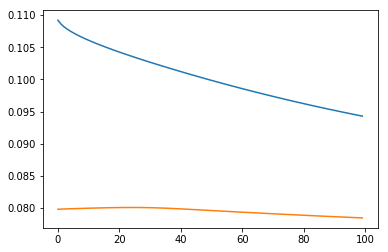

In [101]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

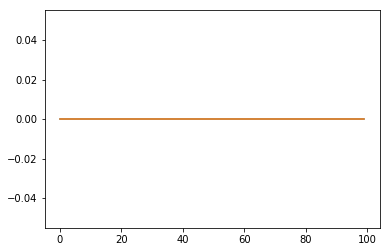

In [102]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

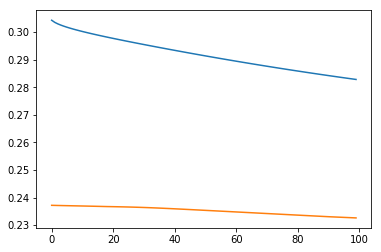

In [103]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

In [19]:
i = 1
encoder_model.predict(x_train)[i]

array([0.38388312], dtype=float32)

In [21]:
y_train[i]

0.3088633118042317

In [22]:
keras.backend.cast_to_floatx(0)

array(0., dtype=float32)

In [114]:
1 * 0.9**10

0.10737418240000006

In [23]:
from keras.utils.generic_utils import get_custom_objects

In [142]:
# saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
def saw(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
    
    return K.tf.where(x < 1, x, K.zeros_like(x))

def sawDescending(x):
     # No gradient defined for operation 'mod' (op type: FloorMod)
    # return x % 1
    return K.tf.where(x > 0, x, K.ones_like(x))
#     return K.tf.where(x > 0, x, x + 1)

get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# make sure to import this function when loading this model in another module

In [143]:
# # saw = Lambda(lambda x: x % 1) # No gradient defined for operation 'mod' (op type: FloorMod)
# def saw(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 1, x, x - 1)

# def sawDescending(x):
#      # No gradient defined for operation 'mod' (op type: FloorMod)
#     # return x % 1
#     return K.tf.where(x < 0, K.ones_like(x), x)

# get_custom_objects().update({'saw': Activation(saw), 'sawDescending': Activation(sawDescending)})

# # make sure to import this function when loading this model in another module

In [154]:
decoder_input = Input(shape=(notes,))
x = decoder_input

unroll = True

ratio = 0.1
sub_t = int(timesteps * ratio)
super_t = int(timesteps/ sub_t)

# a = ELU(alpha=0.5)
# ThresholdedReLU
# PReLU
# ELU
# LeakyRelu

# x1 = starting value
# x2 :: [decay1, decay2, decay3]
# end of sequence = decay3 * (decay2 * (decay1 * x1))
# full sequence = [decay1 * x1, decay2(decay1 * x1), etc... ]

# x1 might have abias of zero
# TODO x1 ** 0.5
# x2 might disregard its input
# TODO check if x2 can have an offset bias

# decay is non-linear?
# decay = 1/f

x1 = x
x1 = Dense(notes, activation='relu')(x1) # phase (linear)
x1 = RepeatVector(1)(x1)

x2 = x
x2 = Dense(notes, activation='relu')(x2) # e.g decay: 0.5 * decay, 0.5 * decay * decay
# x2 = Dense(notes)(x2)
# x2 = Lambda(lambda z: 1./z)(x2) # if descending
# # x2 = Lambda(lambda x: -1 * x)(x2) # if descending

# x2 = Dense(notes, activation='relu')(x2)
x2 = RepeatVector(timesteps)(x2)


# SimpleRNN returns 2 states, LSTM returns 3 states
_, state = SimpleRNN(notes, return_state=True)(x1)
rnn = SimpleRNN(notes, activation='sawDescending', return_sequences=True, unroll=unroll)
# rnn = SimpleRNN(notes, return_sequences=True)
# x = rnn(x2, initial_state=x1) # shape error
x = rnn(x2, initial_state=state)

# # RNN 1
# x = RepeatVector(sub_t)(x)
# x = SimpleRNN(notes, return_sequences=True)(x)

# # RNN 2
# x = Reshape((sub_t,))(x)
# x = RepeatVector(super_t)(x)
# x = Flatten()(x)
# x = Reshape((timesteps,1))(x)
# x = SimpleRNN(notes, return_sequences=True, go_backwards=True)(x)

# x = Dense(1)(x)
# x = ThresholdedReLU(theta=0.5)(x)

# x = Flatten()(x)
# x = Dense(np.prod(input_shape), activation='sigmoid')(x)

# # Final layer
# x = Dense(3, activation='relu')(x)
x = Dense(notes, activation='sigmoid')(x)
x = Reshape(input_shape)(x)

decoder_output = x

decoder_model = Model(decoder_input, decoder_output, name='decoder-')
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
dense_71 (Dense)                (None, 1)            2           input_17[0][0]                   
__________________________________________________________________________________________________
dense_72 (Dense)                (None, 1)            2           input_17[0][0]                   
__________________________________________________________________________________________________
repeat_vector_31 (RepeatVector) (None, 1, 1)         0           dense_71[0][0]                   
__________________________________________________________________________________________________
repeat_vec

In [155]:
loss = 'mse' # mse mae binary_crossentropy rmsprop adadelta
decoder_model.compile(loss=loss, optimizer='rmsprop', metrics=['accuracy','mae','mse'])

In [156]:
batch_size = 1
epochs = 100

In [157]:
j = 2
history = decoder_model.fit(y_train[:j], x_train[:j], epochs=epochs, batch_size=batch_size, validation_data=(y_test, x_test))

Train on 2 samples, validate on 100 samples
Epoch 1/100
2/2 [==============================] - 6s 3s/step - loss: 0.1176 - acc: 0.5700 - mean_absolute_error: 0.2648 - mean_squared_error: 0.1176 - val_loss: 0.1713 - val_acc: 0.3023 - val_mean_absolute_error: 0.3197 - val_mean_squared_error: 0.1713
Epoch 2/100
2/2 [==============================] - 0s 64ms/step - loss: 0.1175 - acc: 0.5700 - mean_absolute_error: 0.2649 - mean_squared_error: 0.1175 - val_loss: 0.1710 - val_acc: 0.3023 - val_mean_absolute_error: 0.3194 - val_mean_squared_error: 0.1710
Epoch 3/100
2/2 [==============================] - 0s 71ms/step - loss: 0.1174 - acc: 0.5700 - mean_absolute_error: 0.2650 - mean_squared_error: 0.1174 - val_loss: 0.1707 - val_acc: 0.3023 - val_mean_absolute_error: 0.3191 - val_mean_squared_error: 0.1707
Epoch 4/100
2/2 [==============================] - 0s 75ms/step - loss: 0.1173 - acc: 0.5700 - mean_absolute_error: 0.2650 - mean_squared_error: 0.1173 - val_loss: 0.1705 - val_acc: 0.3023 -

Epoch 33/100
2/2 [==============================] - 0s 76ms/step - loss: 0.1159 - acc: 0.5700 - mean_absolute_error: 0.2660 - mean_squared_error: 0.1159 - val_loss: 0.1663 - val_acc: 0.3023 - val_mean_absolute_error: 0.3147 - val_mean_squared_error: 0.1663
Epoch 34/100
2/2 [==============================] - 0s 79ms/step - loss: 0.1159 - acc: 0.5700 - mean_absolute_error: 0.2660 - mean_squared_error: 0.1159 - val_loss: 0.1661 - val_acc: 0.3023 - val_mean_absolute_error: 0.3146 - val_mean_squared_error: 0.1661
Epoch 35/100
2/2 [==============================] - 0s 81ms/step - loss: 0.1159 - acc: 0.5700 - mean_absolute_error: 0.2660 - mean_squared_error: 0.1159 - val_loss: 0.1660 - val_acc: 0.3023 - val_mean_absolute_error: 0.3144 - val_mean_squared_error: 0.1660
Epoch 36/100
2/2 [==============================] - 0s 69ms/step - loss: 0.1158 - acc: 0.5700 - mean_absolute_error: 0.2661 - mean_squared_error: 0.1158 - val_loss: 0.1659 - val_acc: 0.3023 - val_mean_absolute_error: 0.3143 - val

Epoch 65/100
2/2 [==============================] - 0s 71ms/step - loss: 0.1149 - acc: 0.5700 - mean_absolute_error: 0.2669 - mean_squared_error: 0.1149 - val_loss: 0.1623 - val_acc: 0.3023 - val_mean_absolute_error: 0.3105 - val_mean_squared_error: 0.1623
Epoch 66/100
2/2 [==============================] - 0s 74ms/step - loss: 0.1148 - acc: 0.5700 - mean_absolute_error: 0.2669 - mean_squared_error: 0.1148 - val_loss: 0.1622 - val_acc: 0.3023 - val_mean_absolute_error: 0.3104 - val_mean_squared_error: 0.1622
Epoch 67/100
2/2 [==============================] - 0s 94ms/step - loss: 0.1148 - acc: 0.5700 - mean_absolute_error: 0.2670 - mean_squared_error: 0.1148 - val_loss: 0.1621 - val_acc: 0.3023 - val_mean_absolute_error: 0.3103 - val_mean_squared_error: 0.1621
Epoch 68/100
2/2 [==============================] - 0s 100ms/step - loss: 0.1148 - acc: 0.5700 - mean_absolute_error: 0.2670 - mean_squared_error: 0.1148 - val_loss: 0.1620 - val_acc: 0.3023 - val_mean_absolute_error: 0.3102 - va

Epoch 97/100
2/2 [==============================] - 0s 65ms/step - loss: 0.1140 - acc: 0.5700 - mean_absolute_error: 0.2679 - mean_squared_error: 0.1140 - val_loss: 0.1586 - val_acc: 0.3023 - val_mean_absolute_error: 0.3064 - val_mean_squared_error: 0.1586
Epoch 98/100
2/2 [==============================] - 0s 82ms/step - loss: 0.1140 - acc: 0.5700 - mean_absolute_error: 0.2679 - mean_squared_error: 0.1140 - val_loss: 0.1585 - val_acc: 0.3023 - val_mean_absolute_error: 0.3063 - val_mean_squared_error: 0.1585
Epoch 99/100
2/2 [==============================] - 0s 81ms/step - loss: 0.1140 - acc: 0.5700 - mean_absolute_error: 0.2680 - mean_squared_error: 0.1140 - val_loss: 0.1584 - val_acc: 0.3023 - val_mean_absolute_error: 0.3062 - val_mean_squared_error: 0.1584
Epoch 100/100
2/2 [==============================] - 0s 73ms/step - loss: 0.1139 - acc: 0.5700 - mean_absolute_error: 0.2680 - mean_squared_error: 0.1139 - val_loss: 0.1583 - val_acc: 0.3023 - val_mean_absolute_error: 0.3060 - va

In [158]:
y_train[:j]

array([0.08007997, 0.30886331])

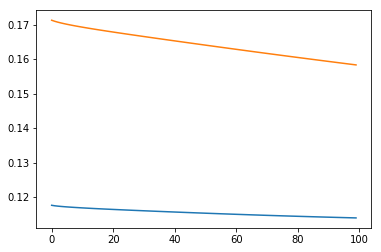

In [159]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

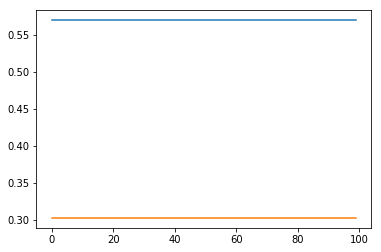

In [160]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

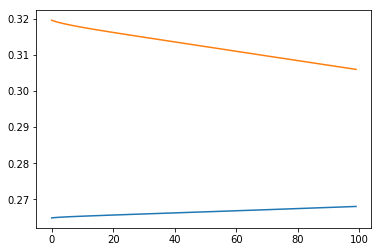

In [161]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])

m (50, 1)


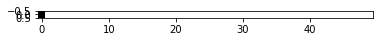

m (50, 1)


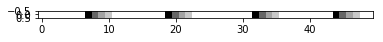

array([0.08007997, 0.30886331])

In [162]:
f = y_train[:10]
y = decoder_model.predict(f)
plot.single(y[0,:50,0])
plot.single(x_train[0,:50,0])
f[:2]

m (50, 1)


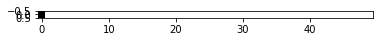

m (50, 1)


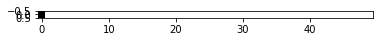

m (50, 1)


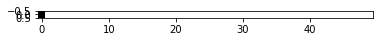

m (50, 1)


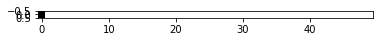

In [163]:
f = [0.1, 0.5, 0.8, 1.4]
y = decoder_model.predict(f)
plot.single(y[0,:50,0])
plot.single(y[1,:50,0])
plot.single(y[2,:50,0])
plot.single(y[3,:50,0])

m (50, 1)


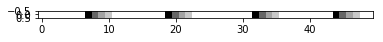

m (50, 1)


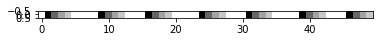

In [80]:
# goal examples
plot.single(x_train[0,:50,0])
plot.single(x_train[1,:50,0])